In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 

In [2]:
rna_sim=pd.read_csv('rna_similarity.txt',sep='\t')
prot_sim=pd.read_csv('prot_similarity.txt',sep='\t')
inter=pd.read_csv('list_of_interactions.txt',sep='\t')

rna_cnt=inter['RNA_ID'].unique().shape[0] # m
prot_cnt=inter['PROT_ID'].unique().shape[0] # n

In [3]:
Sl=np.empty((rna_cnt,rna_cnt))
Sp=np.empty((prot_cnt,prot_cnt))

In [4]:
Y=np.zeros((rna_cnt,prot_cnt))
for i in inter.index:
    Y[inter['RNA_ID'][i]][inter['PROT_ID'][i]]=1
print(Y)

[[1. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
for i in rna_sim.index:
    Sl[rna_sim['RNA(i)'][i]][rna_sim['RNA(j)'][i]]=rna_sim['Sim(i,j)'][i]

for i in prot_sim.index:
    Sp[prot_sim['PROT(i)'][i]][prot_sim['PROT(j)'][i]]=prot_sim['Sim(i,j)'][i]


In [6]:
print(Sl)
print(Sl.shape)

[[1.         0.0160874  0.0150442  ... 0.0213873  0.0237827  0.0301653 ]
 [0.0160874  1.         0.0176763  ... 0.0137041  0.00932855 0.0119166 ]
 [0.0150442  0.0176763  1.         ... 0.0161504  0.0089185  0.0141593 ]
 ...
 [0.0213873  0.0137041  0.0161504  ... 1.         0.00932855 0.016763  ]
 [0.0237827  0.00932855 0.0089185  ... 0.00932855 1.         0.00768836]
 [0.0301653  0.0119166  0.0141593  ... 0.016763   0.00768836 1.        ]]
(990, 990)


In [7]:
print(Sp)
print(Sp.shape)

[[1.         0.0114943  0.0199646  ... 0.0132024  0.0103043  0.0126176 ]
 [0.0114943  1.         0.0154265  ... 0.0111918  0.0101835  0.0238959 ]
 [0.0199646  0.0154265  1.         ... 0.0206388  0.0667203  0.0097399 ]
 ...
 [0.0132024  0.0111918  0.0206388  ... 1.         0.0189189  0.0097399 ]
 [0.0103043  0.0101835  0.0667203  ... 0.0189189  1.         0.00951854]
 [0.0126176  0.0238959  0.0097399  ... 0.0097399  0.00951854 1.        ]]
(64, 64)


In [8]:
def construct_neighbourhood(S,M,K,cnt):
    for i in range(cnt):
        ser=pd.Series(S[i])
        ser.sort_values(ascending=False, inplace=True)
        for iter_cnt, j in enumerate(ser.index):
            if iter_cnt>K:
                break
            if j==i:
                continue
            M[i][j]=ser[j]

K1=5
K2=5

A=np.zeros((rna_cnt,rna_cnt))
B=np.zeros((prot_cnt,prot_cnt))

construct_neighbourhood(Sl,A,K1,rna_cnt)
construct_neighbourhood(Sp,B,K1,prot_cnt)


In [9]:
# construction of Ll
Dl=np.zeros((rna_cnt,rna_cnt))
Dl_=np.zeros((rna_cnt,rna_cnt))

for i in range(rna_cnt):
    Dl[i][i]=np.sum(A[i])
    Dl_[i][i]=np.sum(A[:,i])

Ll=Dl+Dl_-(A+A.transpose())

In [10]:
# construction of Lp
Dp=np.zeros((prot_cnt,prot_cnt))
Dp_=np.zeros((prot_cnt,prot_cnt))

for i in range(prot_cnt):
    Dp[i][i]=np.sum(B[i])
    Dp_[i][i]=np.sum(B[:,i])
    
Lp=Dp+Dp_-(B+B.transpose())

In [11]:
print(Ll)

[[0.6680213 0.        0.        ... 0.        0.        0.       ]
 [0.        0.1620434 0.        ... 0.        0.        0.       ]
 [0.        0.        0.2327686 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.2216763 0.        0.       ]
 [0.        0.        0.        ... 0.        0.3944053 0.       ]
 [0.        0.        0.        ... 0.        0.        0.3830409]]


In [12]:
print(Lp)

[[ 1.2330499   0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.37877098  0.         ...  0.          0.
  -0.0238959 ]
 [ 0.          0.          4.8011551  ...  0.         -0.0667203
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.1811      0.
   0.        ]
 [ 0.          0.         -0.0667203  ...  0.          0.6090052
   0.        ]
 [ 0.         -0.0238959   0.         ...  0.          0.
   0.2156013 ]]


In [13]:
def prob(U,V):
    temp=np.exp(np.matmul(U,V.transpose()))
    return temp/(1+temp)

# P=prob(U,V)
# print(P)

In [14]:
def dL_dU(P,U,V,c,Y,Ll,Lambda_l,alpha,rna_cnt):
    return np.matmul(P,V)+np.matmul(np.multiply(Y,P),V)*(c-1)-np.matmul(Y,V)*c+np.matmul((Lambda_l*np.identity(rna_cnt)+alpha*Ll),U)

def dL_dV(P,U,V,c,Y,Lp,Lambda_p,beta,prot_cnt):
    return np.matmul(P.transpose(),U)+np.matmul(np.multiply(Y.transpose(),P.transpose()),U)*(c-1)-np.matmul(Y.transpose(),U)*c+np.matmul((Lambda_p*np.identity(prot_cnt)+beta*Lp),V)


In [15]:
def grad_des(U,V,Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter):
    phi_l=np.zeros((rna_cnt,r))
    phi_p=np.zeros((prot_cnt,r))
    iter_cnt=1
    cont=True
    while(cont):
        P=prob(U,V)
        prev_U=U.copy()
        prev_V=V.copy()
        
        Gl=dL_dU(P,U,V,c,Y,Ll,Lambda_l,alpha,rna_cnt)
        phi_l=phi_l+np.multiply(Gl,Gl)
        U=U-gamma*(Gl/np.sqrt(phi_l))

        Gp=dL_dV(P,U,V,c,Y,Lp,Lambda_p,beta,prot_cnt)
        phi_p=phi_p+np.multiply(Gp,Gp)
        V=V-gamma*(Gp/np.sqrt(phi_p))
        
        # print(f'Iteration[{iter_cnt}]: ',end='')
        iter_cnt+=1
        # print(V[0])
        
        cont=False
        for i in range(rna_cnt):
            if(np.linalg.norm(U[i]-prev_U[i], ord=1)>1e-3):
                cont=True
                break
        
        for i in range(prot_cnt):
            if(np.linalg.norm(V[i]-prev_V[i], ord=1)>1e-3):
                cont=True
                break
    return U,V


In [16]:
def curve_smoothening(vec,sim,neg_set,K2,cnt,r):
    for i in range(cnt):
        if i in neg_set:
            ser=pd.Series(sim[i])
            ser.sort_values(ascending=False, inplace=True)
            num=np.zeros(r)
            den=0
            nbr_cnt=0
            for j in ser.index:
                if j in neg_set:
                    continue
                num+=sim[i][j]*vec[j]
                den+=sim[i][j]
                nbr_cnt+=1
                if(nbr_cnt>=K2):
                    break
            num/=den
            for k in range(r):
                vec[i][k]=num[k]
    return vec


In [17]:
max_iter=1000

In [18]:
r=20
phi_l=np.zeros((rna_cnt,r))
phi_p=np.zeros((prot_cnt,r))

In [19]:
Lambda_l=0.5
Lambda_p=0.5

sd=1/math.sqrt(r)

In [20]:
U=np.random.normal(0,sd,(rna_cnt,r))
V=np.random.normal(0,sd,(prot_cnt,r))
# P=prob(U,V)
# print(P)

In [21]:
c=5
alpha=1
beta=1
gamma=0.01
# U,V=grad_des(U,V,Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter)

In [22]:
neg_rna_set=[]
neg_prot_set=[]
n=np.random.randint(0,989)
print(n)
print(Y[n])
true_positives=[i for i in range(prot_cnt) if Y[n][i]==1]
true_negatives=[i for i in range(prot_cnt) if Y[n][i]==0]
print(true_positives)
neg_rna_set.append(n)
modified_Y=Y.copy()
for i in range(prot_cnt):
    modified_Y[n][i]=0

704
[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 2, 4, 10, 24, 39]


In [23]:
U,V=grad_des(U,V,modified_Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter)

In [24]:
U=curve_smoothening(U,Sl,neg_rna_set,K2,rna_cnt,r)
V=curve_smoothening(V,Sp,neg_prot_set,K2,prot_cnt,r)

In [25]:
P=prob(U,V)
ser=pd.Series(P[n])
ser.sort_values(ascending=False, inplace=True)
for i in ser.index:
    print(i," ",ser[i])
pred=ser.to_numpy()
print(pred)

4   0.9650501003455667
1   0.9507978073407548
6   0.5088011927934774
0   0.07337313173122813
24   0.060061285615454665
2   0.04955070273509108
13   0.048689852023077476
12   0.03791237418162468
18   0.033460444649744236
10   0.03003514711648726
3   0.01573304645312535
34   0.015379470991131598
11   0.01381753896178119
22   0.012912386980120361
40   0.012369245772235936
16   0.012320643428856276
43   0.011610195211490013
9   0.011435531976532938
14   0.011237719049362683
8   0.011108580020944493
5   0.010937030526946634
29   0.010316920266279334
21   0.010154040848788006
28   0.009954476424403325
15   0.009186596334757647
25   0.009035295229629415
30   0.008981568293784612
7   0.007799578790936813
27   0.0077003514737671586
54   0.007613640018922033
39   0.007516313191981701
44   0.007139785452378383
35   0.0067326513071138926
26   0.006594924379019107
31   0.006389206941895918
33   0.006151241385552646
32   0.006095655294407571
49   0.005957061366554381
42   0.005907784473161377
51   0

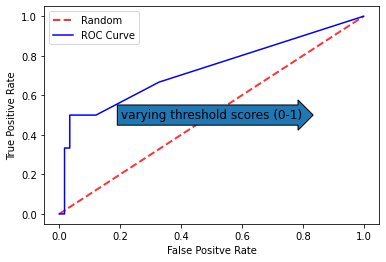

In [26]:
thresholds = np.linspace(0,1,100)
tpr=[]
fpr=[]
pos=len(true_positives)
fal=len(true_negatives)
for th in thresholds:
    tp=0
    fp=0
    for i in range(64):
        if pred[i]<th:
            break
        if i in true_positives:
            tp+=1
        else:
            fp+=1
    tpr.append(tp/pos)
    fpr.append(fp/fal)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)
plt.plot(fpr,tpr, label="ROC Curve",color="blue")
plt.text(0.5, 0.5, "varying threshold scores (0-1)", rotation=0, size=12,ha="center", va="center",bbox=dict(boxstyle="rarrow"))
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [72]:
np.savetxt('U_values_6.txt',U)
np.savetxt('V_values_6.txt',V)
np.savetxt('P_6.txt',prob(U,V))